In [1]:
import torch
import torch.nn as nn
from tqdm import tqdm
import numpy as np
import os


# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyperparameters
batch_size = 16
learning_rate = 1e-4
num_classes = 4

# Dataset Paths
# dataset_dir ='/kaggle/input/corrected-ml-classification-data/Dataset'
# test_dir ='/kaggle/input/corrected-ml-classification-data/Dataset/test'


# Including clipping

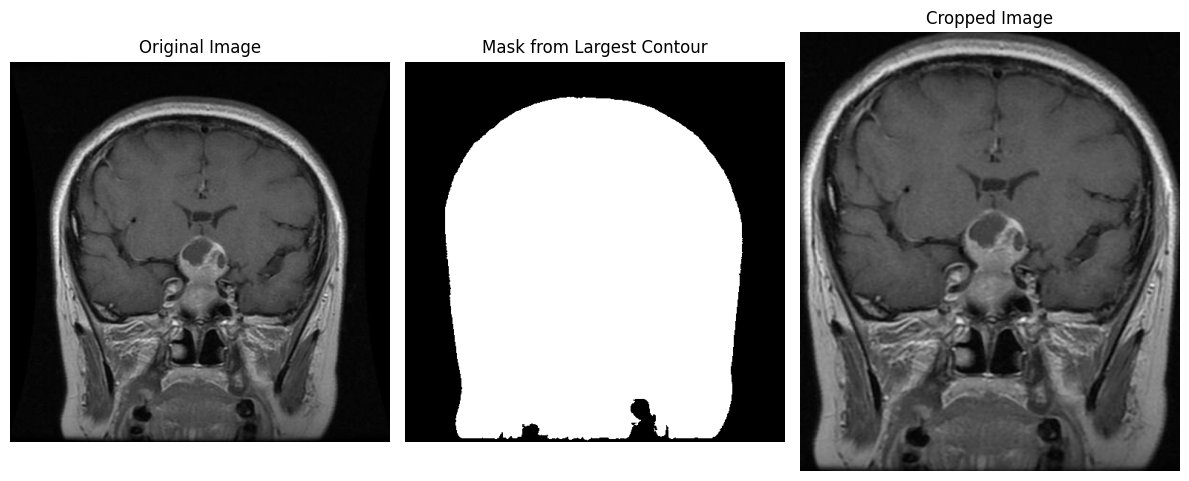

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def clip(image_path):
    image = cv2.imread(image_path)
    
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # largest contour
    largest_contour = max(contours, key=cv2.contourArea)
    
    mask = np.zeros_like(gray)
    cv2.drawContours(mask, [largest_contour], -1, color=255, thickness=cv2.FILLED)
    # result = cv2.bitwise_and(image, image, mask=mask)
    x, y, w, h = cv2.boundingRect(largest_contour)
    cropped = image[y:y+h, x:x+w]

    return image, mask, cropped

# results

image_path = '/kaggle/input/corrected-ml-classification-data/Dataset/train/pituitary_tumor/p (109).jpg'
image, mask,cropped=clip(image_path)

plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
plt.title("Original Image")
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis("off")

plt.subplot(1, 3, 2)
plt.title("Mask from Largest Contour")
plt.imshow(mask, cmap="gray")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.title("Cropped Image")
plt.imshow(cv2.cvtColor(cropped, cv2.COLOR_BGR2RGB))
plt.axis("off")

plt.tight_layout()
plt.show()


In [3]:
def process_dataset(input_dir, output_dir):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    # Create output directories for cropped images and masks
    cropped_dir = os.path.join(output_dir, 'cropped')
    os.makedirs(cropped_dir, exist_ok=True)
    
    # Loop through all subfolders and images
    for root, _, files in os.walk(input_dir):
        for file in tqdm(files, desc="Processing images"):
            if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                image_path = os.path.join(root, file)
                
                # Apply clipping
                _,_,cropped = clip(image_path)
                
                # Define new paths
                rel_path = os.path.relpath(root, input_dir)  # Maintain relative directory structure
                os.makedirs(os.path.join(cropped_dir, rel_path), exist_ok=True)

                # Save cropped image and mask
                cropped_path = os.path.join(cropped_dir, rel_path, file)
                cv2.imwrite(cropped_path, cropped)

    print("Processing complete. Files saved to:", output_dir)


input_dataset_dir = '/kaggle/input/corrected-ml-classification-data/Dataset'  # Replace with your input dataset path
output_dataset_dir = '/kaggle/working/dataset'  # Directory to save cropped images and masks

# Process the dataset
process_dataset(input_dataset_dir, output_dataset_dir)


Processing images: 0it [00:00, ?it/s]
Processing images: 0it [00:00, ?it/s]
Processing images: 100%|██████████| 100/100 [00:00<00:00, 102.71it/s]
Processing images: 0it [00:00, ?it/s]
Processing images: 100%|██████████| 826/826 [00:07<00:00, 104.95it/s]

Processing complete. Files saved to: /kaggle/working/dataset


In [4]:

dataset_dir ='/kaggle/working/dataset/cropped'
test_dir ='/kaggle/working/dataset/cropped/test'

In [5]:
!pip install ultralytics
!pip install ipywidgets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 899.0/899.0 kB 16.0 MB/s eta 0:00:00


In [6]:
from ultralytics import YOLO

# Load YOLO classification model
model = YOLO('yolov8n-cls.pt')  # Pretrained YOLOv8 model for classification

# Train on custom dataset
model.train(
    data=dataset_dir,  # Dataset folder organized by class
    epochs=30,               # Training epochs
    batch=16,                # Batch size
    imgsz=224                # Image size (224x224)
)

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


100%|██████████| 5.31M/5.31M [00:00<00:00, 73.1MB/s]


Ultralytics 8.3.50 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=classify, mode=train, model=yolov8n-cls.pt, data=/kaggle/working/dataset/cropped, epochs=30, time=None, patience=100, batch=16, imgsz=224, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_

100%|██████████| 5.35M/5.35M [00:00<00:00, 74.4MB/s]


AMP: checks passed ✅


train: Scanning /kaggle/working/dataset/cropped/train... 2870 images, 0 corrupt: 100%|██████████| 2870/2870 [00:01<00:00, 1974.98it/s]

train: New cache created: /kaggle/working/dataset/cropped/train.cache



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /kaggle/working/dataset/cropped/test... 394 images, 0 corrupt: 100%|██████████| 394/394 [00:00<00:00, 2023.74it/s]


val: New cache created: /kaggle/working/dataset/cropped/test.cache
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 26 weight(decay=0.0), 27 weight(decay=0.0005), 27 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 224 train, 224 val
Using 2 dataloader workers
Logging results to runs/classify/train
Starting training for 30 epochs...

      Epoch    GPU_mem       loss  Instances       Size


       1/30     0.289G      1.409         16        224:   4%|▍         | 7/180 [00:00<00:16, 10.19it/s]

       1/30     0.289G      1.445         16        224:   7%|▋         | 12/180 [00:01<00:12, 13.13it/s]
100%|██████████| 755k/755k [00:00<00:00, 19.5MB/s]
               classes   top1_acc   top5_acc: 100%|██████████| 13/13 [00:00<00:00, 18.34it/s]

                   all      0.571          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 13/13 [00:00<00:00, 19.01it/s]

                   all      0.685          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 13/13 [00:00<00:00, 18.12it/s]

                   all      0.766          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 13/13 [00:00<00:00, 19.48it/s]

                   all      0.749          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 13/13 [00:00<00:00, 18.64it/s]

                   all      0.797          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 13/13 [00:00<00:00, 14.89it/s]

                   all      0.802          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 13/13 [00:00<00:00, 18.98it/s]

                   all       0.83          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 13/13 [00:00<00:00, 17.59it/s]

                   all      0.807          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 13/13 [00:00<00:00, 17.88it/s]

                   all      0.812          1



      Epoch    GPU_mem       loss  Instances       Size


      10/30     0.264G     0.1567          6        224: 100%|██████████| 180/180 [00:10<00:00, 16.68it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 13/13 [00:00<00:00, 18.61it/s]

                   all      0.789          1



      Epoch    GPU_mem       loss  Instances       Size


      11/30     0.264G     0.1399          6        224: 100%|██████████| 180/180 [00:10<00:00, 16.45it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 13/13 [00:00<00:00, 18.45it/s]

                   all       0.82          1



      Epoch    GPU_mem       loss  Instances       Size


      12/30     0.264G     0.1303          6        224: 100%|██████████| 180/180 [00:11<00:00, 15.84it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 13/13 [00:00<00:00, 18.10it/s]

                   all      0.817          1



      Epoch    GPU_mem       loss  Instances       Size


      13/30     0.264G     0.1311          6        224: 100%|██████████| 180/180 [00:10<00:00, 16.37it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 13/13 [00:00<00:00, 18.50it/s]

                   all      0.825          1



      Epoch    GPU_mem       loss  Instances       Size


      14/30     0.264G     0.1057          6        224: 100%|██████████| 180/180 [00:11<00:00, 15.78it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 13/13 [00:00<00:00, 19.10it/s]

                   all      0.807          1



      Epoch    GPU_mem       loss  Instances       Size


      15/30     0.264G     0.1271          6        224: 100%|██████████| 180/180 [00:10<00:00, 16.55it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 13/13 [00:00<00:00, 19.22it/s]

                   all      0.822          1



      Epoch    GPU_mem       loss  Instances       Size


      16/30     0.264G     0.1069          6        224: 100%|██████████| 180/180 [00:11<00:00, 16.31it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 13/13 [00:00<00:00, 17.94it/s]

                   all      0.835          1



      Epoch    GPU_mem       loss  Instances       Size


      17/30     0.264G        0.1          6        224: 100%|██████████| 180/180 [00:11<00:00, 15.87it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 13/13 [00:00<00:00, 19.75it/s]

                   all      0.805          1



      Epoch    GPU_mem       loss  Instances       Size


      18/30     0.264G     0.0733          6        224: 100%|██████████| 180/180 [00:11<00:00, 16.20it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 13/13 [00:00<00:00, 18.51it/s]

                   all      0.812          1



      Epoch    GPU_mem       loss  Instances       Size


      19/30     0.264G    0.08313          6        224: 100%|██████████| 180/180 [00:11<00:00, 16.35it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 13/13 [00:00<00:00, 18.38it/s]

                   all       0.82          1



      Epoch    GPU_mem       loss  Instances       Size


      20/30     0.264G    0.08719          6        224: 100%|██████████| 180/180 [00:11<00:00, 16.25it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 13/13 [00:00<00:00, 17.66it/s]

                   all      0.822          1



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem       loss  Instances       Size


      21/30     0.264G    0.08465          6        224: 100%|██████████| 180/180 [00:11<00:00, 15.99it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 13/13 [00:00<00:00, 19.07it/s]

                   all      0.825          1



      Epoch    GPU_mem       loss  Instances       Size


      22/30     0.264G    0.08526          6        224: 100%|██████████| 180/180 [00:11<00:00, 15.75it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 13/13 [00:00<00:00, 18.07it/s]

                   all       0.83          1



      Epoch    GPU_mem       loss  Instances       Size


      23/30     0.264G    0.07962          6        224: 100%|██████████| 180/180 [00:10<00:00, 16.37it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 13/13 [00:00<00:00, 20.45it/s]

                   all       0.82          1



      Epoch    GPU_mem       loss  Instances       Size


      24/30     0.264G     0.0745          6        224: 100%|██████████| 180/180 [00:10<00:00, 16.40it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 13/13 [00:00<00:00, 18.42it/s]

                   all      0.825          1



      Epoch    GPU_mem       loss  Instances       Size


      25/30     0.264G    0.07257          6        224: 100%|██████████| 180/180 [00:11<00:00, 15.87it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 13/13 [00:00<00:00, 18.99it/s]

                   all      0.827          1



      Epoch    GPU_mem       loss  Instances       Size


      26/30     0.264G    0.06195          6        224: 100%|██████████| 180/180 [00:11<00:00, 16.31it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 13/13 [00:00<00:00, 17.82it/s]

                   all      0.815          1



      Epoch    GPU_mem       loss  Instances       Size


      27/30     0.264G    0.07174          6        224: 100%|██████████| 180/180 [00:11<00:00, 15.75it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 13/13 [00:00<00:00, 19.71it/s]

                   all      0.815          1



      Epoch    GPU_mem       loss  Instances       Size


      28/30     0.264G    0.07193          6        224: 100%|██████████| 180/180 [00:11<00:00, 16.17it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 13/13 [00:00<00:00, 19.95it/s]

                   all      0.807          1



      Epoch    GPU_mem       loss  Instances       Size


      29/30     0.264G    0.06479          6        224: 100%|██████████| 180/180 [00:11<00:00, 16.22it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 13/13 [00:00<00:00, 19.59it/s]

                   all      0.807          1



      Epoch    GPU_mem       loss  Instances       Size


      30/30     0.264G    0.05938          6        224: 100%|██████████| 180/180 [00:11<00:00, 15.89it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 13/13 [00:00<00:00, 17.21it/s]

                   all      0.812          1



30 epochs completed in 0.104 hours.
Optimizer stripped from runs/classify/train/weights/last.pt, 3.0MB
Optimizer stripped from runs/classify/train/weights/best.pt, 3.0MB

Validating runs/classify/train/weights/best.pt...
Ultralytics 8.3.50 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n-cls summary (fused): 73 layers, 1,440,004 parameters, 0 gradients, 3.3 GFLOPs
WARNING ⚠️ Dataset 'split=val' not found, using 'split=test' instead.
train: /kaggle/working/dataset/cropped/train... found 2870 images in 4 classes ✅ 
val: None...
test: /kaggle/working/dataset/cropped/test... found 394 images in 4 classes ✅ 


               classes   top1_acc   top5_acc: 100%|██████████| 13/13 [00:00<00:00, 17.32it/s]


                   all      0.835          1
Speed: 0.1ms preprocess, 0.3ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to runs/classify/train


ultralytics.utils.metrics.ClassifyMetrics object with attributes:

confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7bb1734031f0>
curves: []
curves_results: []
fitness: 0.9175126850605011
keys: ['metrics/accuracy_top1', 'metrics/accuracy_top5']
results_dict: {'metrics/accuracy_top1': 0.8350253701210022, 'metrics/accuracy_top5': 1.0, 'fitness': 0.9175126850605011}
save_dir: PosixPath('runs/classify/train')
speed: {'preprocess': 0.07125205800012889, 'inference': 0.2825647441263731, 'loss': 0.000642640941639237, 'postprocess': 0.0008060242318865007}
task: 'classify'
top1: 0.8350253701210022
top5: 1.0

In [7]:
# Predict on new images

# test_dir ='/kaggle/input/corrected-ml-classification-data/Dataset/test/glioma_tumor'
# predictions = model.predict(source=test_dir, imgsz=224)
# print("-----------\n",predictions[1])
# print("-----------\n",predictions[1].probs)
# print("-----------\n",predictions[5])
# print("-----------\n",predictions[5].probs)
# print("-----------\n",predictions[5].probs.top1)

In [8]:
import os

# Test directory
test_dir = '/kaggle/working/dataset/cropped/test'

# Initialize variables for accuracy calculation
correct = 0
total = 0
class_total=[]
class_correct=[]

for class_name in os.listdir(test_dir):
    class_path = os.path.join(test_dir, class_name)
    if not os.path.isdir(class_path):
        continue 
    
    # Predict on all images in this class
    for image_name in os.listdir(class_path):
        image_path = os.path.join(class_path, image_name)
        
        # Run YOLO prediction
        results = model.predict(source=image_path, imgsz=224)
        
        # Extract predicted class
        predicted_class_id = results[0].probs.top1  # First prediction's class ID
        predicted_class_name = results[0].names[predicted_class_id]
        
        # Compare with ground truth (class_name)
        if predicted_class_name == class_name:
            correct += 1
        total += 1
    class_total.append(total)
    class_correct.append(correct)

# Calculate and print accuracy
accuracy = 100.0 * correct / total
print(f"Prediction Accuracy: {accuracy:.2f}%")
class_correct[1]-=class_correct[0]
class_total[1]-=class_total[0]
print("correct", class_correct)
print("total", class_total)


image 1/1 /kaggle/working/dataset/cropped/test/no_tumor/image(44).jpg: 224x224 no_tumor 1.00, meningioma_tumor 0.00, pituitary_tumor 0.00, glioma_tumor 0.00, 2.8ms
Speed: 11.0ms preprocess, 2.8ms inference, 0.1ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /kaggle/working/dataset/cropped/test/no_tumor/image(50).jpg: 224x224 no_tumor 0.99, meningioma_tumor 0.00, glioma_tumor 0.00, pituitary_tumor 0.00, 2.8ms
Speed: 2.8ms preprocess, 2.8ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /kaggle/working/dataset/cropped/test/no_tumor/image(90).jpg: 224x224 no_tumor 0.99, pituitary_tumor 0.00, meningioma_tumor 0.00, glioma_tumor 0.00, 5.3ms
Speed: 4.9ms preprocess, 5.3ms inference, 0.1ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 /kaggle/working/dataset/cropped/test/no_tumor/image(43).jpg: 224x224 no_tumor 1.00, meningioma_tumor 0.00, pituitary_tumor 0.00, glioma_tumor 0.00, 5.1ms
Speed: 4.6ms preprocess, 5.1ms inference, 0.1ms pos

In [9]:
#metric
tn=class_correct[0]
tp=class_correct[1]
fn=class_total[0]-class_correct[0]
fp=class_total[1]-class_correct[1]
print(tn,tp,fn,fp)

precision=tp/(tp+fp)
recall=tp/(tp+fn)
specificity=tn/(tn+fp)
_f1=2*precision*recall/(precision+recall)
print('Precision:',precision)
print('Recall:',recall)
print('Specificity:',specificity)
print('F1-score:',_f1)


105 53 0 21
Precision: 0.7162162162162162
Recall: 1.0
Specificity: 0.8333333333333334
F1-score: 0.8346456692913385


In [10]:
# !rm -rf /kaggle/working/dataset